In [5]:
import sys
import os

import json
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import Resize
import torch.nn.functional as F

from datasets import Dataset, Features, Value
from datasets import Image as HFImage
from transformers import AutoImageProcessor, AutoModel

# OADino embedding evaluation (from data.py outputs)
This section reproduces the attribute-level retrieval evaluation using the embeddings saved by `data.py`.

In [6]:
import itertools
import pickle
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DINOv2 ViT-S/14 + transforms (for completeness)
dino_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").to(device).eval()
dino_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def load_embedding_pair(single_dir, multi_dir):
    single_dir = Path(single_dir)
    multi_dir = Path(multi_dir)

    with open(single_dir / "single_embeddings.pkl", "rb") as f:
        single_emb = pickle.load(f)
    with open(single_dir / "single_metadata.pkl", "rb") as f:
        single_meta = pickle.load(f)

    with open(multi_dir / "multi_embeddings.pkl", "rb") as f:
        multi_emb = pickle.load(f)
    with open(multi_dir / "multi_metadata.pkl", "rb") as f:
        multi_meta = pickle.load(f)

    return single_emb, single_meta, multi_emb, multi_meta

def stack_dino(dino_list):
    return torch.stack([d if torch.is_tensor(d) else torch.tensor(d) for d in dino_list], dim=0)

def pool_latents(latents_list):
    pooled = []
    latent_dim = None
    for lat in latents_list:
        t = lat if torch.is_tensor(lat) else torch.tensor(lat)
        if latent_dim is None and t.numel() > 0:
            latent_dim = t.shape[1]
        if t.numel() == 0:
            pooled.append(torch.zeros(latent_dim if latent_dim else 1))
        else:
            pooled.append(t.mean(dim=0))
    return torch.stack(pooled, dim=0)

def get_coords(meta, idx):
    if "world_coords" in meta:
        return meta["world_coords"][idx]
    if "3d_coords" in meta:
        return meta["3d_coords"][idx]
    return None

def match_count_and_dist(query_meta, cand_meta, attr_keys):
    # query is single-object
    q_attrs = {k: query_meta[k][0] for k in attr_keys}
    q_coords = get_coords(query_meta, 0)
    n = cand_meta["num_objects"]
    matches = 0
    distances = []
    for i in range(n):
        ok = True
        for k in attr_keys:
            if cand_meta[k][i] != q_attrs[k]:
                ok = False
                break
        if ok:
            matches += 1
            c_coords = get_coords(cand_meta, i)
            if q_coords is not None and c_coords is not None:
                distances.append(float(np.linalg.norm(np.array(q_coords) - np.array(c_coords))))
    return matches, distances

def weighted_precision(matches):
    weights = np.array([1.0 / (i + 1) for i in range(len(matches))], dtype=np.float32)
    return float((weights * np.array(matches, dtype=np.float32)).sum() / weights.sum())

def evaluate_retrieval(query_feats, cand_feats, query_meta, cand_meta, topk=10, attr_keys=("color","shape","size","material")):
    q = F.normalize(query_feats, dim=1)
    c = F.normalize(cand_feats, dim=1)
    sims = q @ c.T
    topk = min(topk, cand_feats.shape[0])

    precisions = []
    w_precisions = []
    mean_match_counts = []
    mean_distances = []

    for i in range(sims.shape[0]):
        idx = torch.topk(sims[i], k=topk).indices.tolist()
        matches = []
        match_counts = []
        all_distances = []
        for j in idx:
            count, distances = match_count_and_dist(query_meta[i], cand_meta[j], attr_keys)
            matches.append(count > 0)
            match_counts.append(count)
            all_distances.extend(distances)
        precisions.append(sum(matches) / topk)
        w_precisions.append(weighted_precision(matches))
        mean_match_counts.append(float(np.mean(match_counts)))
        mean_distances.append(float(np.mean(all_distances)) if len(all_distances) else float("nan"))

    return {
        "precision": float(np.mean(precisions)),
        "wprecision": float(np.mean(w_precisions)),
        "match_count": float(np.mean(mean_match_counts)),
        "distance": float(np.nanmean(mean_distances)),
    }

def build_attr_subsets():
    mapping = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    keys = list(mapping.keys())
    subsets = []
    for r in [1, 2, 3, 4]:
        for combo in itertools.permutations(keys, r):
            subset_name = "".join(combo)
            subset_keys = tuple(mapping[k] for k in combo)
            subsets.append((subset_name, subset_keys))
    return subsets

EMB_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/data/CLEVR_CLEVRTex_train_4K_224_VAE16_20260213_151319/embeddings"
single_emb, single_meta, multi_emb, multi_meta = load_embedding_pair(
    f"{EMB_PATH}/single_object",
    f"{EMB_PATH}/multi_object",
)

single_dino = stack_dino(single_emb["dino_cls"])
multi_dino = stack_dino(multi_emb["dino_cls"])
single_vae = pool_latents(single_emb["vae_latents"])
multi_vae = pool_latents(multi_emb["vae_latents"])
alpha = 40.0
single_combo = torch.cat([single_dino, alpha * single_vae], dim=1)
multi_combo = torch.cat([multi_dino, alpha * multi_vae], dim=1)

# Filter queries (single-object) and candidates (multi-object)
single_idx = [i for i, m in enumerate(single_meta) if m["num_objects"] == 1]
multi_idx = [i for i, m in enumerate(multi_meta) if m["num_objects"] > 1]

single_dino = single_dino[single_idx]
single_vae = single_vae[single_idx]
single_combo = single_combo[single_idx]
single_meta = [single_meta[i] for i in single_idx]

multi_dino = multi_dino[multi_idx]
multi_vae = multi_vae[multi_idx]
multi_combo = multi_combo[multi_idx]
multi_meta = [multi_meta[i] for i in multi_idx]

print("Loaded:", single_dino.shape, multi_dino.shape)

Using cache found in C:\Users\maril/.cache\torch\hub\facebookresearch_dinov2_main


Loaded: torch.Size([39, 384]) torch.Size([392, 384])


In [ ]:
# Evaluate DINO-only, VAE-only, and DINO+VAE retrieval with sampling
topk = 10
full_keys = ("color", "shape", "size", "material")
num_runs = 7
num_queries = 50
rng = np.random.default_rng(42)

def sample_query_indices(n_total, n_samples):
    n_samples = min(n_samples, n_total)
    return rng.choice(n_total, size=n_samples, replace=False)

def run_sampled_eval(query_feats, cand_feats, query_meta, cand_meta):
    metrics = []
    for _ in range(num_runs):
        idx = sample_query_indices(len(query_meta), num_queries)
        qf = query_feats[idx]
        qm = [query_meta[i] for i in idx]
        metrics.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=full_keys))
    return metrics

def summarize_metrics(metrics_list):
    keys = metrics_list[0].keys()
    out = {}
    for k in keys:
        vals = [m[k] for m in metrics_list]
        out[k] = {"mean": float(np.mean(vals)), "std": float(np.std(vals))}
    return out

dino_metrics = run_sampled_eval(single_dino, multi_dino, single_meta, multi_meta)
vae_metrics = run_sampled_eval(single_vae, multi_vae, single_meta, multi_meta)
combo_metrics = run_sampled_eval(single_combo, multi_combo, single_meta, multi_meta)

print("DINO-only:", summarize_metrics(dino_metrics))
print("VAE-only:", summarize_metrics(vae_metrics))
print("DINO+VAE:", summarize_metrics(combo_metrics))

DINO-only: {'precision': {'mean': 0.03428571428571429, 'std': 0.01678191446352962}, 'wprecision': {'mean': 0.03304430118628911, 'std': 0.022180349353061176}, 'match_count': {'mean': 0.037142857142857144, 'std': 0.019059520091609054}, 'distance': {'mean': 4.495538287861857, 'std': 0.7791827815003527}}
VAE-only: {'precision': {'mean': 0.05857142857142857, 'std': 0.025872528966106905}, 'wprecision': {'mean': 0.08508718801396234, 'std': 0.0315803849033474}, 'match_count': {'mean': 0.0642857142857143, 'std': 0.03331972511340171}, 'distance': {'mean': 3.3044088717111846, 'std': 0.327047314104322}}
DINO+VAE: {'precision': {'mean': 0.055714285714285716, 'std': 0.02610809554642438}, 'wprecision': {'mean': 0.058942842483520504, 'std': 0.027549229563499072}, 'match_count': {'mean': 0.05857142857142857, 'std': 0.02849991049037143}, 'distance': {'mean': 4.283117048116452, 'std': 0.5601957048757757}}


In [8]:
# Attribute ablation for DINO-only, VAE-only, DINO+VAE (sampled queries)
subsets = build_attr_subsets()
results = {"dino": {}, "vae": {}, "combo": {}}

def run_sampled_ablation(query_feats, cand_feats, query_meta, cand_meta):
    ablation_metrics = {}
    for name, keys in subsets:
        per_run = []
        for _ in range(num_runs):
            idx = sample_query_indices(len(query_meta), num_queries)
            qf = query_feats[idx]
            qm = [query_meta[i] for i in idx]
            per_run.append(evaluate_retrieval(qf, cand_feats, qm, cand_meta, topk=topk, attr_keys=keys))
        # store mean/std for this subset
        ablation_metrics[name] = {
            "precision": {"mean": float(np.mean([m["precision"] for m in per_run])), "std": float(np.std([m["precision"] for m in per_run]))},
"wprecision": {"mean": float(np.mean([m["wprecision"] for m in per_run])), "std": float(np.std([m["wprecision"] for m in per_run]))},
"match_count": {"mean": float(np.mean([m["match_count"] for m in per_run])), "std": float(np.std([m["match_count"] for m in per_run]))},
"distance": {"mean": float(np.mean([m["distance"] for m in per_run])), "std": float(np.std([m["distance"] for m in per_run]))},
        }
    return ablation_metrics

results["dino"] = run_sampled_ablation(single_dino, multi_dino, single_meta, multi_meta)
results["vae"] = run_sampled_ablation(single_vae, multi_vae, single_meta, multi_meta)
results["combo"] = run_sampled_ablation(single_combo, multi_combo, single_meta, multi_meta)

def summarize(results_dict):
    length_groups = {1: [], 2: [], 3: [], 4: []}
    for name, metrics in results_dict.items():
        length_groups[len(name)].append(metrics["precision"]["mean"])
    means = {k: float(np.mean(v)) for k, v in length_groups.items() if len(v) > 0}
    stds = {k: float(np.std(v)) for k, v in length_groups.items() if len(v) > 0}
    return means, stds

def ablation_removed_attributes(results_dict):
    full = set(["C", "D", "S", "M"])
    removed = {}
    for name in results_dict.keys():
        removed[name] = "".join(sorted(full - set(name)))
    return removed

def single_attribute_ablation(results_dict):
    removed_map = {"C": "color", "D": "shape", "S": "size", "M": "material"}
    out = {}
    for rem_key in ["C", "D", "S", "M"]:
        filtered = {k: v for k, v in results_dict.items() if rem_key not in k}
        out[removed_map[rem_key]] = {
            "mean": float(np.mean([v["precision"]["mean"] for v in filtered.values()])),
            "std": float(np.std([v["precision"]["mean"] for v in filtered.values()])),
        }
    return out

for key in ["dino", "vae", "combo"]:
    means, stds = summarize(results[key])
    removed = ablation_removed_attributes(results[key])
    single_removals = single_attribute_ablation(results[key])
    print("\n", key.upper(), "ablation")
    print("mean precision by length:", means)
    print("std precision by length:", stds)
    print("removed attributes per subset (C/D/S/M removed):", list(removed.items())[:10])
    print("single-attribute ablation (remove one at a time):", single_removals)

C:\Users\maril\AppData\Local\Temp\ipykernel_1132\1983788670.py:114: RuntimeWarning: Mean of empty slice
  "distance": float(np.nanmean(mean_distances)),



 DINO ablation
mean precision by length: {1: 0.6610714285714286, 2: 0.3028571428571429, 3: 0.11327380952380954, 4: 0.036250000000000004}
std precision by length: {1: 0.22177938799350927, 2: 0.15873436502363242, 3: 0.06591516807295698, 4: 0.005294273957276284}
removed attributes per subset (C/D/S/M removed): [('C', 'DMS'), ('D', 'CMS'), ('S', 'CDM'), ('M', 'CDS'), ('CD', 'MS'), ('CS', 'DM'), ('CM', 'DS'), ('DC', 'MS'), ('DS', 'CM'), ('DM', 'CS')]
single-attribute ablation (remove one at a time): {'color': {'mean': 0.4013333333333334, 'std': 0.22395484643702265}, 'shape': {'mean': 0.23361904761904756, 'std': 0.22365173769332228}, 'size': {'mean': 0.22742857142857142, 'std': 0.22285848595443872}, 'material': {'mean': 0.3322857142857144, 'std': 0.27547648269318165}}

 VAE ablation
mean precision by length: {1: 0.7275, 2: 0.3511904761904762, 3: 0.14785714285714285, 4: 0.05613095238095237}
std precision by length: {1: 0.1892530295231056, 2: 0.11748184594644454, 3: 0.04265428179095319, 4: 0.

Loaded 40 single-object images and 400 multi-object images
CLEVR query (simple objects):


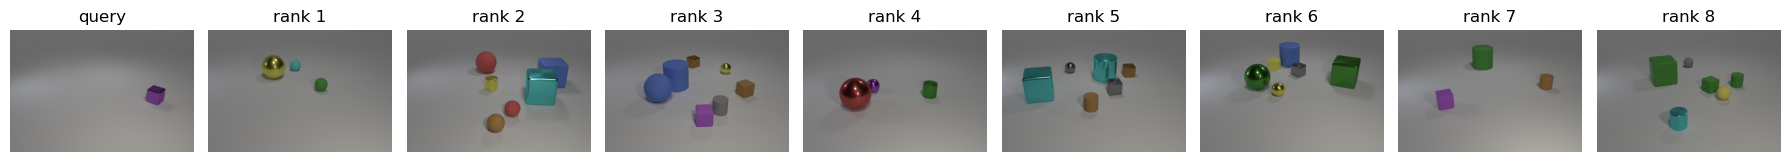


CLEVRTex query (textured objects):


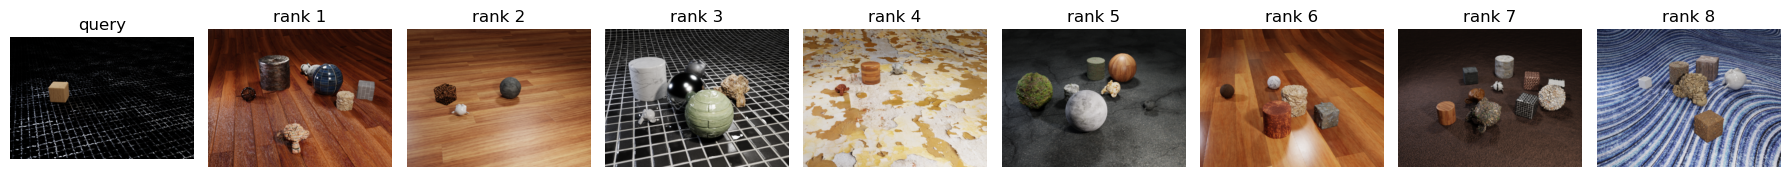

In [9]:
# Retrieval visualization
import matplotlib.pyplot as plt
from PIL import Image

def load_clevr_image_paths(image_dir, scenes_json, keep_single, max_images=None):
    """Load CLEVR-style dataset with single scenes.json file"""
    image_dir = Path(image_dir)
    scenes_json = Path(scenes_json)
    with open(scenes_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    scenes = data.get("scenes", [])
    paths = []
    for scene in scenes:
        objects = scene.get("objects", [])
        is_single = len(objects) == 1
        if keep_single != is_single:
            continue
        filename = scene.get("image_filename")
        if filename is None:
            image_index = scene.get("image_index")
            split = scene.get("split", "val")
            if image_index is None:
                continue
            filename = f"CLEVR_{split}_{image_index:06d}.png"
        path = image_dir / filename
        if path.exists():
            paths.append(path)
        if max_images is not None and len(paths) >= max_images:
            break
    return paths

def load_clevrtex_image_paths(image_dir, keep_single, max_images=None):
    """Load CLEVRTex-style dataset with per-image JSON files"""
    image_dir = Path(image_dir)
    paths = []
    
    # Find all PNG files
    image_files = sorted(image_dir.glob("*.png"))
    
    for image_path in image_files:
        # Corresponding JSON file has the same name
        json_path = image_path.with_suffix(".json")
        
        if not json_path.exists():
            continue
            
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                scene_data = json.load(f)
        except Exception as e:
            print(f"Warning: Failed to load {json_path}: {e}")
            continue
            
        objects = scene_data.get("objects", [])
        is_single = len(objects) == 1
        if keep_single != is_single:
            continue
            
        paths.append(image_path)
        
        if max_images is not None and len(paths) >= max_images:
            break
            
    return paths

def load_image_paths_from_sources(sources, keep_single):
    """Load image paths from multiple sources (CLEVR and/or CLEVRTex)"""
    all_paths = []
    
    for src in sources:
        image_dir = src["image_dir"]
        use_per_image_json = src.get("use_per_image_json", False)
        max_images = src.get("max_images")
        
        if use_per_image_json or "scenes_json" not in src:
            # CLEVRTex-style: per-image JSON files
            paths = load_clevrtex_image_paths(image_dir, keep_single, max_images)
        else:
            # CLEVR-style: single scenes.json file
            scenes_json = src["scenes_json"]
            paths = load_clevr_image_paths(image_dir, scenes_json, keep_single, max_images)
        
        all_paths.extend(paths)
    
    return all_paths

# Define sources for both single and multi-object images
DATASET_PATH = "C:/Users/maril/OneDrive/Desktop/GitHub/OADino/oadino/dataset"

single_sources = [
    {
        "image_dir": Path(DATASET_PATH + "/single/images_single"),
        "scenes_json": Path(DATASET_PATH + "/single/CLEVR_single_scenes.json"),
        "dataset_name": "clevr",
        "max_images": 20,
    },
    {
        "image_dir": Path(DATASET_PATH + "/single/CLEVRTex_single/clevrtex_single/0"),
        "use_per_image_json": True,
        "dataset_name": "clevrtex",
        "max_images": 20,
    }
]

multi_sources = [
    {
        "image_dir": Path(DATASET_PATH + "/multi/CLEVR_v1.0/images/val"),
        "scenes_json": Path(DATASET_PATH + "/multi/CLEVR_v1.0/scenes/CLEVR_val_scenes.json"),
        "dataset_name": "clevr",
        "max_images": 200,
    },
    {
        "image_dir": Path(DATASET_PATH + "/multi/clevrtex_full/0"),
        "use_per_image_json": True,
        "dataset_name": "clevrtex",
        "max_images": 200,
    }
]

single_paths = load_image_paths_from_sources(single_sources, keep_single=True)
multi_paths = load_image_paths_from_sources(multi_sources, keep_single=False)

print(f"Loaded {len(single_paths)} single-object images and {len(multi_paths)} multi-object images")

def retrieve_indices(query_idx, topk=8, mode="combo"):
    if mode == "dino":
        q = single_dino
        c = multi_dino
    elif mode == "vae":
        q = single_vae
        c = multi_vae
    else:
        q = single_combo
        c = multi_combo
    sims = F.normalize(q, dim=1) @ F.normalize(c, dim=1).T
    topk = min(topk, c.shape[0])
    return torch.topk(sims[query_idx], k=topk).indices.tolist()

def show_retrieval(query_idx=0, topk=8, mode="combo"):
    idxs = retrieve_indices(query_idx, topk=topk, mode=mode)
    fig, axes = plt.subplots(1, topk + 1, figsize=(2 * (topk + 1), 3))
    # Query image
    q_path = single_paths[query_idx]
    axes[0].imshow(Image.open(q_path))
    axes[0].set_title("query")
    axes[0].axis("off")
    # Retrieved candidates
    for i, j in enumerate(idxs, start=1):
        c_path = multi_paths[j]
        axes[i].imshow(Image.open(c_path))
        axes[i].set_title(f"rank {i}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Example: CLEVR query
print("CLEVR query (simple objects):")
show_retrieval(query_idx=0, topk=8, mode="combo")

# Example: CLEVRTex query (textured objects)
print("\nCLEVRTex query (textured objects):")
show_retrieval(query_idx=24, topk=8, mode="combo")